# Daymet V4 - Programmatic Data Discovery, Access, Subsetting, and Download for Analysis Ready Data

*Author:  ORNL DAAC*
<br>
*Date: August 31, 2021*
<br>
*Contact for [ORNL DAAC](https://daac.ornl.gov/):  uso@daac.ornl.gov*

##### Keywords:  ORNL DAAC, Daymet, THREDDS, OPeNDAP, Earthdata, `CMR API`, Python, `pydap`, `xarray`

# Tutorial Overview

**In this tutorial, we're interested in obtaining gridded weather data that covers the spatial region of the Great Smoky Mountains National Park.  We'll learn to programmatically subset data from the North American Daymet V4 Daily data for the precipitation variable. We'll further subset data for 2 years; 2010 and 2011.**

**We'll learn to search NASA's Dataset Collections and Granules to discover the Daymet files that matches our user-defined search parameters.  Using Python Geospatial libraries and modules, we'll programmatically access and subset data for download.**  

![title](images/NPS_great-smoky-mountains-national-park-map.jpg)  <h5><center>Great Smoky Mountains National Park</center></h1>

### Daymet Overview
**Daymet** provides long-term, continuous, gridded estimates of daily weather and climatology variables by interpolating and extrapolating ground-based observations through statistical modeling techniques. 

![title](images/Daymet_V4_Annual_Climatology_Fig1.png)

Daily files are produced on a **1km x 1km** spatial grid and distributed in a multidimensional, netCDF, file format. Daymet data is available for continenal North America (na), with Hawaii (hi), and Puerto Rico (pr) as separate data files.

DAYMET Temporal Availability:

| Spatial Area    | Years                          
|:---------       |:---------------------------------------:|
| North America   | 1980 - present
| Hawaii          | 1980 - 2020
| Puerto Rico     | 1950 - 2020

DAYMET VARIABLES:

| Variable | Description (units)                           
|:---------|:---------------------------------------:|
| tmax     | Daily maximum 2-meter air temperature (°C)
| tmin     | Daily minimum 2-meter air temperature (°C)
| prcp     | Daily total precipitation (mm/day)
| srad     | Incident shortwave radiation flux density (W/m2)
| vp       | Water vapor pressure (Pa)
| swe      | Snow water equivalent (kg/m2)
| dayl     | Duration of the daylight period (seconds/day)


Daymet V4 Daily Data files (or granules) are natively in netCDF4 format, and each file has one year's worth of data. Data files are organized by variables (dayl, prcp, tmin, tmax, srad, swe, vp) and regions (each for na, pr, hi).

The standard naming convention for a file is:  

- daymet_v4_daily_`area`_`variable`_`year`.nc


#### Daymet Data: ORNL DAAC 
- The [Daymet Website](https://daymet.ornl.gov) provides comprehensive information about and access methods for the Daymet datasets under the [Get Data](https://daymet.ornl.gov/getdata) tab. 

- Landing Page for [Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1840).  
- Daymet V4 Daily Data dataset DOI **https://doi.org/10.3334/ORNLDAAC/1840**
<div class="alert alert-block alert-info">
Thornton, M.M., R. Shrestha, Y. Wei, P.E. Thornton, S. Kao, and B.E. Wilson. 2020. Daymet: Daily Surface Weather Data on a 1-km Grid for North America, Version 4. ORNL DAAC, Oak Ridge, Tennessee, USA. https://doi.org/10.3334/ORNLDAAC/1840
</div>


- ORNL DAAC access to Daymet daily data through THREDDS Data Server (TDS) [Daymet V4 Daily Data: THREDDS](https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/1840/catalog.html)

#### Daymet Data: NASA Earthdata
 - [NASA Earthdata Daymet Collections](https://search.earthdata.nasa.gov/portal/ornldaac/search?fpj=Daymet!Daymet!Daymet)

***
***

# Tutorial

Steps we'll explore in this tutorial are: 
1.  Using a georeferenced polygon file, we'll establish **boundary parameters** to use as input for subsetting Daymet Data
1. We'll leverage the `Daymet Dataset DOI` and NASA's Common Metadata Repository `(CMR) API` to obtain a list of Daymet files within our spatial and temporal region of interest
1. Programmatically download subsets of data via OPeNDAP 
1. Clip the Daymet subset to our polygon region of interest

## Tutorial Python and Module/Library Versions
* Python 3.7 or higher
* geopandas and dependencies
* pydap
* xarray
* rasterio
* shapely

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import pyproj
import datetime as dt 
from rasterio.features import Affine
from pydap.client import open_url
from pydap.cas.urs import setup_session
import xarray as xr
import rioxarray
import shapely
import rasterio
import time
from shapely.geometry import mapping
from datetime import date

In [2]:
print("This Notebook was produced with the following versions")
print("geopanda version   : ", gpd.__version__)
print("pyproj version     : ", pyproj.__version__)
print("rioxarray version  : ", rioxarray.__version__)
print("xarray version     : ", xr.__version__)
print("shapely            : ", shapely.__version__)
print("rasterio           : ", rasterio.__version__)

This Notebook was produced with the following versions
geopanda version   :  0.9.0
pyproj version     :  2.6.1.post1
rioxarray version  :  0.7.1
xarray version     :  0.19.0
shapely            :  1.7.1
rasterio           :  1.1.1


## Step 1.  Setting Search and Subset Parameters: Spatial Area of Interest and Time Range of Interest

We will use a vector shape file of the [Great Smoky Mountains National Park (GRSM)](https://www.nps.gov/grsm/planyourvisit/maps.htm) to obtain boundary parameters to use in demonstrating a programmatic spatial subsetting process. 

We'll use Python's [GeoPandas](https://geopandas.org/index.html) to provide a spatial extent from a the polygon file.

* **`Geopandas`** is a Python library that enables the use and manipulation of geospatial data. It extends the common datatype used in pandas to allow for many and unique geometric operations.

In [ ]:
grsm_poly = gpd.read_file('bnds/GRSM_BOUNDARY_POLYGON_fid17.shp')
ax = grsm_poly.plot() # boundary file of the Great Smokey Mountains National Park

grsm_poly.crs  # Lists the coordinate reference system (crs)

<Projected CRS: EPSG:26917>
Name: NAD83 / UTM zone 17N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - 84°W to 78°W and NAD83 by country
- bounds: (-84.0, 23.81, -78.0, 84.0)
Coordinate Operation:
- name: UTM zone 17N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

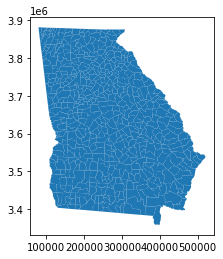

In [4]:
ga_shape = gpd.read_file(r'C:\Users\samsh\OneDrive\Documents\Productivity\GIS\Research Projects\Marshep\Data\GA_NAD83_UTM17N.shp')
# ga_shape = gpd.read_file(r'C:\Users\samsh\OneDrive\Documents\Productivity\GIS\Research Projects\Marshep\Data\tl_2019_13_tract.shp')
ax = ga_shape.plot()

ga_shape.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

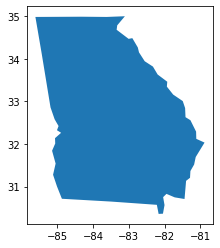

In [3]:
ga_shape = gpd.read_file(r'C:\Users\samsh\OneDrive\Documents\Productivity\GIS\Research Projects\Marshep\Data\GA_stateBoundary.shp')
# ga_shape = gpd.read_file(r'C:\Users\samsh\OneDrive\Documents\Productivity\GIS\Research Projects\Marshep\Data\tl_2019_13_tract.shp')
ax = ga_shape.plot()

ga_shape.crs

As we see above, the boundary file is in the `UTM 17N` projection. Daymet is project to the `lambert_conformal_conic (LCC)` system. 

### Re-project vector file using the **`GeoDataFrame.to_crs`** 
We'll need bounding box coordinates in 2 reference systems
1. **Geographic** - for searching NASA Earthdata metadata
2. **Lambert Conformal Conic** - Daymet's crs - for subsetting the file using OPeNDAP protocols

### 1.1 **Geographic** bounding box - for searching NASA Earthdata metadata

In [ ]:
# Let's determine and store the geographic bounding box of the Park boundary for Earthdata Searching
# data can be re-projected using the GeoDataFrame.to_crs() command:
grsm_poly_4326 = grsm_poly.to_crs(epsg=4326) #EPSG code for WGS84
xy = grsm_poly_4326.bounds # bound of polygon in lat, lon 
print(xy)

In [ ]:
ga_shape_4269 = ga_shape.to_crs(epsg=4326) # Dont need to reproject because already in NAD1983 and no projection applied
xy1 = ga_shape_4269.bounds
print(xy1) # Look at creating complex polygon so that the geometry does not change subsetting upon DAYMET overlay

In [4]:
# ga_shape_4269 = ga_shape.to_crs(epsg=4326) # Dont need to reproject because already in WGS84 and no projection applied
xy1 = ga_shape.bounds
print(xy1) # Look at creating complex polygon so that the geometry does not change subsetting upon DAYMET overlay

        minx       miny       maxx      maxy
0 -85.606675  30.356734 -80.885553  35.00118


In [ ]:
xy = grsm_poly_4326.bounds.values.tolist()[0] # We'll need the bounding box as a Python list 
                                              # to server as a subsetting parameter
print(xy)

In [5]:
xy1 = ga_shape.bounds.values.tolist()[0] # We'll need the bounding box as a Python list 
                                              # to server as a subsetting parameter
# xy1 = [-85.605165, 30.357851, -80.839729, 35.000659]
print(xy1)

[-85.606675, 30.356734, -80.885553, 35.00118]


### 1.2. **Lambert Conformal Conic** bounding box - Daymet's CRS - for subsetting the file using OPeNDAP protocols

In [ ]:
#defining Daymet proj - we'll use this in a later step
daymet_proj = "+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs"
grsm_poly_lcc = grsm_poly.to_crs(daymet_proj) # to_crs re-projects from UTM 17N to LCC
lccbounds = grsm_poly_lcc.bounds # Bounds in LCC projection
lccbounds.round(2)

In [6]:
#defining Daymet proj - we'll use this in a later step
daymet_proj = "+proj=lcc +ellps=WGS84 +a=6378137 +b=6356752.314245 +lat_1=25 +lat_2=60 +lon_0=-100 +lat_0=42.5 +x_0=0 +y_0=0 +units=m +no_defs"
ga_shape_lcc = ga_shape.to_crs(daymet_proj) # to_crs re-projects from NAD 1983 to LCC
lccbounds = ga_shape_lcc.bounds # Bounds in LCC projection
lccbounds.round(2)

,minx,miny,maxx,maxy
0,1259685.37,-1129705.22,1738456.68,-646896.28


In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
#grsm_poly.plot(ax=ax1, facecolor='blue');
grsm_poly_4326.plot(ax=ax1, facecolor='blue');
ax1.set_title("GRSM Geographic Coordinate System");
grsm_poly_lcc.plot(ax=ax2, facecolor='grey');
ax2.set_title("GRSM Daymet LCC Projection");
plt.tight_layout()

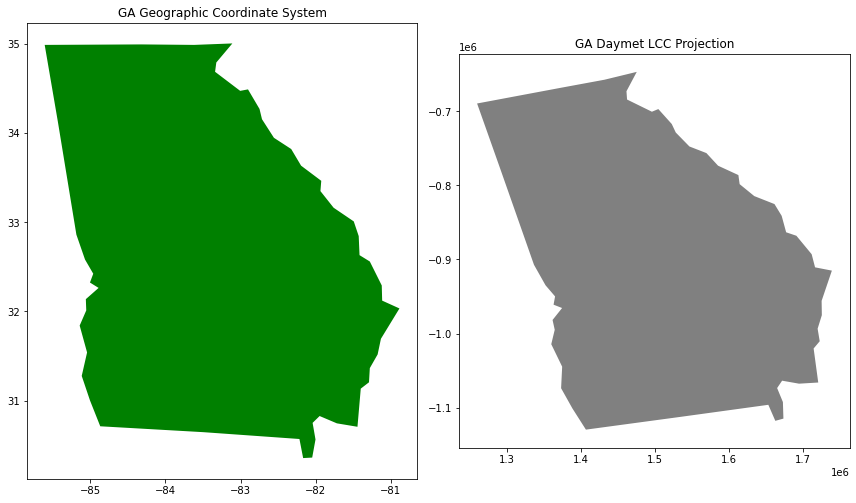

In [7]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
#ga_shape.plot(ax=ax1, facecolor='blue');
ga_shape.plot(ax=ax1, facecolor='green');
ax1.set_title("GA Geographic Coordinate System");
ga_shape_lcc.plot(ax=ax2, facecolor='gray');
ax2.set_title("GA Daymet LCC Projection");
plt.tight_layout()

### 1.3. Let's also define a `time range` in a format that the API recognizes, and the Daymet `variable` of interest

In [45]:
start_date = dt.datetime(2000, 1, 1) # specify your own start date
end_date = dt.datetime(2005, 1, 1)  # specify your end start date

dt_format = '%Y-%m-%dT%H:%M:%SZ' # format requirement for datetime search
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

var = 'prcp' # select a Daymet variable of interest
print(temporal_str)
print(var)

2000-01-01T00:00:00Z,2005-01-01T00:00:00Z
prcp


----

## Step 2. Leveraging NASA's Common Metadata Repository (CMR) API to search for Daymet data within a spatial and temporal region of interest

##### Now that we've defined our spatial and temporal area-of-interest, we'll see how we can programatically use those as a search parameters to discover Daymet V4 Daily data.  

##### At the end of this step, we will have a list of Daymet files that are within our search criteria (bounding box and time period).

#### A little background ...

- Searching [NASA's Earthdata Holdings](https://search.earthdata.nasa.gov/search) can lead to quite a few files for a user to consider. 
![title](images/InkedNASAEarthdataCollectionSearch_narrow_LI.jpg)
<br>

Some helpful background:
- NASA has a metadata system that catalogs all data and metadata records:  [Common Metadata Repository (CMR)](https://earthdata.nasa.gov/eosdis/science-system-description/eosdis-components/cmr) 

- Using the [CMR API](https://cmr.earthdata.nasa.gov/search), we can search metadata records to discovered data granules (files).


**`Request URL's`**
<div class="alert alert-block alert-info">
https://cmr.earthdata.nasa.gov/search/collections
</div>

<div class="alert alert-block alert-info">
https://cmr.earthdata.nasa.gov/search/granules
</div>

- The [Daymet V4 Daily](https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1840) data DOI, **`doi.org/10.3334/ORNLDAAC/1840`**.
   

### 2.1. Searching NASA's Earthdata Collections for Daymet V4 Daily Data "`Concept ID`"

#### The **`Concept ID`** is a NASA Earthdata unique ID for **Dataset Collections**.  We'll see how to programatically obtain the Concept ID below.

Using Python's **`requests`** library, we will build and provide an HTTP request to search **`NASA's Earthdata Collections`** for Daymet V4 Daily Dataset Collection to acquire the **`concept_id`** unique to the Daymet V4 Daily data in NASA's Earthdata holdings.  

* **`requests`** is a simple HTTP libray for Python.  It allows you to easily send HTTP requests.

<div class="alert alert-block alert-info">
https://cmr.earthdata.nasa.gov/search/collections
</div>

To build the URL Request we'll use:
- the CMR Request URL
- Daymet V4 Daily Data DOI


In [46]:
daymet_doi = '10.3334/ORNLDAAC/1840' # define the Daymet V4 Daily Data DOI as the variable `daymet_doi`
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
doisearch = cmrurl + 'collections.json?doi=' + daymet_doi # Create the Earthdata Collections URL
print('Earthdata Collections URL: Daymet V4 Daily -->', doisearch)

Earthdata Collections URL: Daymet V4 Daily --> https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.3334/ORNLDAAC/1840


In [47]:
# From the doisearch, we can obtain the ConceptID for the Daymet V4 Daily data
# We'll search the json response of the Daymet metadata for "id" within the 'entry' dictionary key
response = requests.get(doisearch)
collection = response.json()['feed']['entry'][0] 
#print(collection)
concept_id = collection['id']
print('NASA Earthdata Concept_ID --> ' , concept_id)

NASA Earthdata Concept_ID -->  C2031536952-ORNL_CLOUD


`C2031536952-ORNL_CLOUD` is the unique NASA-given Concept ID for the Daymet V4 Daily data Collection. We'll use this to search for Daymet V4 Daily files (granules) that match our search criteria. 

### 2.2. Searching NASA's Earthdata Holdings for Daymet `Granules` (Files)
#### Now that we have all our parameters defined, let's search NASA's Earthdata Granules for all the data that are within those search criteria.

<div class="alert alert-block alert-info">
https://cmr.earthdata.nasa.gov/search/granules
</div>


In [48]:
print('Variables we have defined to pass to the CMR API')
print('-----------------------------------------------')
print('time range      :', temporal_str)
print('Daymet variable :', var)
print('bounding box    :')
print(xy1)
print('concept ID      :', concept_id)
print('cmr url         :', cmrurl)

Variables we have defined to pass to the CMR API
-----------------------------------------------
time range      : 2000-01-01T00:00:00Z,2005-01-01T00:00:00Z
Daymet variable : prcp
bounding box    :
[-85.606675, 30.356734, -80.885553, 35.00118]
concept ID      : C2031536952-ORNL_CLOUD
cmr url         : https://cmr.earthdata.nasa.gov/search/


### 2.2.a. We'll build a Request URL `granulesearch` to create a listing of all the granules (files) in NASA's Earthdata holdings that fit the search criteria we defined.

In [49]:
granulesearch = cmrurl + 'granules.json?collection_concept_id=' + concept_id + \
                '&page_size=1000' + '&temporal=' + temporal_str + \
                '&bounding_box[]=' + ','.join(map(str, xy1))
print(granulesearch)                

https://cmr.earthdata.nasa.gov/search/granules.json?collection_concept_id=C2031536952-ORNL_CLOUD&page_size=1000&temporal=2000-01-01T00:00:00Z,2005-01-01T00:00:00Z&bounding_box[]=-85.606675,30.356734,-80.885553,35.00118


### 2.2.b. Again using Python's **`requests`** library, we can provide the URL `granulesearch` to create a listing of all the granules (files) in **NASA's Earthdata** holdings that fit the search criteria we defined.

In [50]:
response = requests.get(granulesearch)
granules = response.json()['feed']['entry']  # Michele, look at url feed, 'entry' key in the granulesearch URL {}
granule_names = []  # create an empty array
for g in granules:
    granule_name = g['title'] # fill the array with granule names that match our search parameters
    if var in granule_name:
        granule_names.append(granule_name)
        print(granule_name)

Daymet_Daily_V4.daymet_v4_daily_na_prcp_2000.nc
Daymet_Daily_V4.daymet_v4_daily_na_prcp_2001.nc
Daymet_Daily_V4.daymet_v4_daily_na_prcp_2002.nc
Daymet_Daily_V4.daymet_v4_daily_na_prcp_2003.nc
Daymet_Daily_V4.daymet_v4_daily_na_prcp_2004.nc
Daymet_Daily_V4.daymet_v4_daily_na_prcp_2005.nc


##### Now the array `granule_names` contains the names of all the files that have data in the Great Smoky Mountains Park and for our time period.
##### In other words, of the 1,071 files in the Daymet V4 Daily Collection, these 2 files match our search criteria.

----

## Step 3. Downloading subset data through ORNL DAAC THREDDS Data Server
Daymet V4 Daily data is available through ORNL DAAC's THREDDS Data Server. 


[Daymet V4 Daily Data in the ORNL DAAC THREDDS Data Server](https://thredds.daac.ornl.gov/thredds/catalog/ornldaac/1840/catalog.html)

### 3.1. **`OPeNDAP`** allows users to use data files that are stored on remote computers with their favorite analysis and visualization client software.

NASA Earthdata has great informaion on OPeNDAP: [What is OPeNDAP](https://earthdata.nasa.gov/collaborate/open-data-services-and-software/api/opendap)

### 3.1.a. We'll use Pythons **`pydap`** library

* **`pydap`** can be used to inspect data from any scientific dataset available on the internet from OPeNDAP servers. This allows inspection and manipulation of scientific data as if it were stored locally.  Data can be downloaded on-the-fly as needed.

### 3.1.b. We'll use Python's **`Xarray`** Library to 
* open the data files we are searching for, 
* subset the North American file based on the Lambert Conformal Conic **`lccbounds`** bounding box we defined earlier, 
* concatenate the time range of files into one file, and 
* save the concatened file to a netCDF file.

Pydap
* **open_url**

Xarray
* **open_dataset** 
* **slice**
* **concat**
* **to_netcdf**

We will subset and download Daymet V4 Daily Data based on
- **`granule_names`** array we saved above 
- our polygonal region of interest (LCC bounding box)
- our time range of interest
- Daymet variable



**Note:** The beginning of the **`granule_names`** filename (**"Daymet_Daily_V4."**) is specific to the Earthdata naming convention.  We'll strip out (**"Daymet_Daily_V4."**) below when we access the files from the on-prem ORNL DAAC's OPeNDAP client through THREDDS.

In [52]:
#from pydap.client import open_url
#import xarray as xr
#import time

thredds_url = 'https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1840/' # ORNL DAAC TDS OPeNDAP URL 
                                                                           # for Daymet V4 Daily Files

before = time.time()
cnt = 0 
for g_name in granule_names:
    print(' ***GRANULE_NAME*** ---->', g_name)
    granule_dap = thredds_url + g_name.replace('Daymet_Daily_V4.','')
    print(granule_dap)
    
    # Using pydap's open_url 
    thredds_ds = open_url(granule_dap) 
    
    # Xarray DataSet - opening dataset via remote OPeNDAP 
    ds = xr.open_dataset(xr.backends.PydapDataStore(thredds_ds), decode_coords="all")
        
    temp=ds['prcp'].sel(x=slice(lccbounds.minx[0],lccbounds.maxx[0]), y=slice(lccbounds.maxy[0],lccbounds.miny[0]))
    
    if cnt==0:
        prcp = temp
    else:
        prcp = xr.concat([prcp, temp], dim="time")
    
    cnt += 1
    

# save to netcdf
prcp.to_netcdf(var + '_tdssubset.nc')
print("Processing Time: ", time.time() - before, 'seconds')
# Processing Time:  50.4509379863739 seconds

 ***GRANULE_NAME*** ----> Daymet_Daily_V4.daymet_v4_daily_na_prcp_2000.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1840/daymet_v4_daily_na_prcp_2000.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4.daymet_v4_daily_na_prcp_2001.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1840/daymet_v4_daily_na_prcp_2001.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4.daymet_v4_daily_na_prcp_2002.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1840/daymet_v4_daily_na_prcp_2002.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4.daymet_v4_daily_na_prcp_2003.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1840/daymet_v4_daily_na_prcp_2003.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4.daymet_v4_daily_na_prcp_2004.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1840/daymet_v4_daily_na_prcp_2004.nc
 ***GRANULE_NAME*** ----> Daymet_Daily_V4.daymet_v4_daily_na_prcp_2005.nc
https://thredds.daac.ornl.gov/thredds/dodsC/ornldaac/1840/daymet_v4_daily_na_prcp_2005.nc
Processing Time:

### 3.2 Visualize Daymet Precipitation Subset

In [ ]:
prcp_grsm = prcp.isel(time=6) # isel = xarray index selection (python index start from 0, so time is Jan 7, 2010)
fig, ax = plt.subplots(figsize = (20,10))
prcp_grsm.plot(ax=ax, robust=True, cbar_kwargs={'label': 'mm/day'})
grsm_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'red')

<AxesSubplot:title={'center':'time = 2000-01-07T12:00:00, lambert_conformal_c...'}, xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

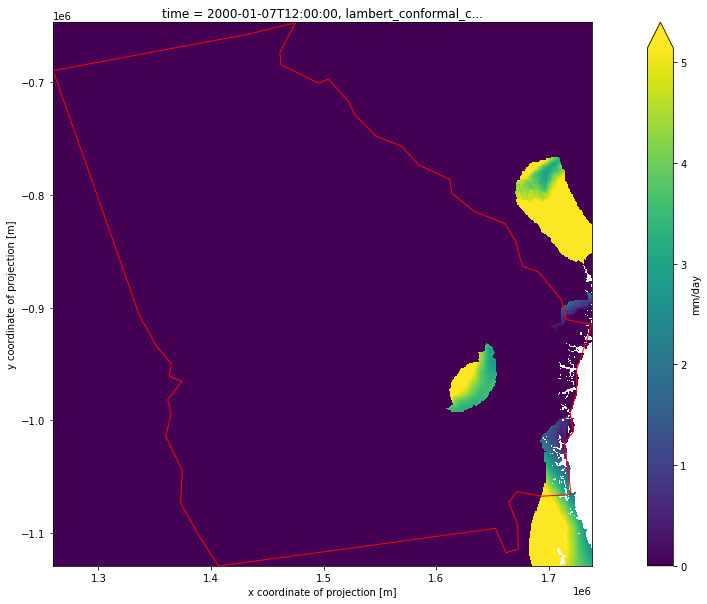

In [53]:
prcp_ga = prcp.isel(time=6) # isel = xarray index selection (python index start from 0, so time is Jan 7, 2010)
fig, ax = plt.subplots(figsize = (20,10))
prcp_ga.plot(ax=ax, robust=True, cbar_kwargs={'label': 'mm/day'})
ga_shape_lcc.plot(ax = ax, color = 'none', edgecolor = 'red')

In [16]:
prcp

<xarray.DataArray 'prcp' (time: 730, y: 483, x: 479)>
array([[[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        ...,
        [ 0.77,  0.83,  0.79, ..., 20.4 , 21.21, 13.79],
        [ 0.77,  0.86,  0.74, ..., 21.36, 14.43, 12.45],
        [ 0.73,  0.82,  0.74, ..., 15.71, 12.91, 12.29]],

       [[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        ...,
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]],

       [[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        ...,
...
        ...,
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]],

       [[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        ...,
        [ 0.9 ,  0.86,  0.82, ...,  0.  ,  0.  ,  0.  ],
        [ 0.92,  0.88,  0.84, ...,  0.  ,  0.  ,  0.  ],
        [ 0.94,  0.9 ,  0.86, ...,  0.  ,  0.  ,  0.  ]],

       [[ 1.21,  1.17,  1.12, ...,  0.  ,  0.  ,  0.  ],
        [ 1.27,  1.21,  1.17, ...,  0.  ,  0.  ,  0.  ],
        [ 1.3 ,  1.24,  1.17, ...,  0.  ,  0.  ,  0.  ],
        ...,
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ]]], dtype=float32)
Coordinates:
  * x                        (x) float32 1.26e+06 1.261e+06 ... 1.738e+06
  * y                        (y) float32 -6.47e+05 -6.48e+05 ... -1.129e+06
    lat                      (y, x) float32 35.38 35.38 35.37 ... 30.11 30.1
    lon                      (y, x) float32 -85.52 -85.51 ... -81.42 -81.41
  * time                     (time) datetime64[ns] 2010-01-01T12:00:00 ... 20...
    lambert_conformal_conic  int16 -32767
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    cell_methods:  area: mean time: sum
    _ChunkSizes:   [1, 1000, 1000]

----

## Step 4. Clipping the subset area by polygon
In this step, we demonstrate how to clip the subset to our polygon of interest.  We'll use Python's *rasterio* library.

* **`rasterio`** provides many capabilities found in GDAL

First, we'll map the subset precipitation data matrix to real world coordinates using the **'translation'** and **'scale'** methods of **'Affine'**.

**`rasterio`** needs the affine transform parameter to convert polygon into a mask

In [54]:
from rasterio.features import Affine
res = 1000 # daymet spatial resolution is 1km x 1km
transform = Affine.translation(min(prcp.x).values - res / 2, min(prcp.y).values - res / 2) * Affine.scale(res, res)
transform

Affine(1000.0, 0.0, 1259250.0,
       0.0, 1000.0, -1129500.0)

- We'll use the `transform` defined above and mask the prcp data to the park boundary

In [55]:
from rasterio.features import geometry_mask
grsm_mask = geometry_mask(grsm_poly_lcc.geometry, out_shape=(len(prcp.y), len(prcp.x)), transform=transform, invert=True)
polymask = xr.DataArray(grsm_mask , dims=("y", "x"))
polymask = polymask.sel(y=slice(None, None, -1)) 
prcp_masked = prcp.where(polymask == True)
prcp_masked.to_netcdf(var + '_subset_poly.nc')

NameError: name 'grsm_poly_lcc' is not defined

In [56]:
from rasterio.features import geometry_mask
ga_mask = geometry_mask(ga_shape_lcc.geometry, out_shape=(len(prcp.y), len(prcp.x)), transform=transform, invert=True)
polymask = xr.DataArray(ga_mask , dims=("y", "x"))
polymask = polymask.sel(y=slice(None, None, -1)) 
prcp_masked = prcp.where(polymask == True)
prcp_masked.to_netcdf(var + '_subset_poly.nc')

Now let's plot the subset for a day, this time using Xarray's **sel** method for time

In [ ]:
import matplotlib.pyplot as plt
prcp_1 = prcp_masked.sel(time="2010-01-07")
fig, ax = plt.subplots(figsize = (20,10))
prcp_1.plot(ax=ax, robust=True, cbar_kwargs={'label': 'mm/day'})
grsm_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'red')

<AxesSubplot:title={'center':'time = 2004-02-10T12:00:00, lambert_conformal_c...'}, xlabel='x coordinate of projection [m]', ylabel='y coordinate of projection [m]'>

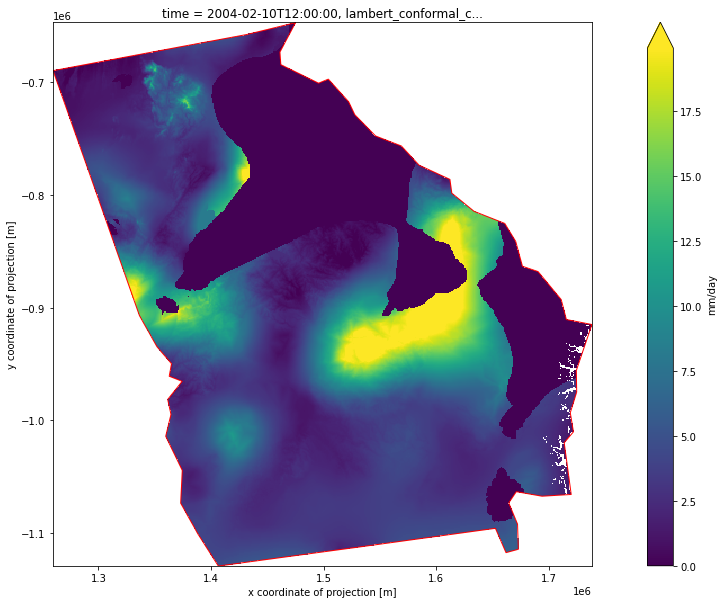

In [62]:
import matplotlib.pyplot as plt
prcp_1 = prcp_masked.sel(time="2004-02-10")
fig, ax = plt.subplots(figsize = (20,10))
prcp_1.plot(ax=ax, robust=True, cbar_kwargs={'label': 'mm/day'})
ga_shape_lcc.plot(ax = ax, color = 'none', edgecolor = 'red')

#### Another way to clip and Saving to a GeoTIFF
The subset data can also be clipped by a polygon of interest and converted to GeoTiff using the rioxarray and shapely libraries.

* **`rioxarray`** is an extention of xarray.  It can be used to clip, merge, and reproject rasters
* **`shapely`** is a Python package for manipulation and analysis of planar geometery objects

In [23]:
import rioxarray
from shapely.geometry import mapping

prcp_sub = rioxarray.open_rasterio(var + '_tdssubset.nc',  masked=True)
prcp_clip = prcp_sub.prcp.rio.clip(grsm_poly_lcc.geometry.apply(mapping), grsm_poly_lcc.crs, invert=False, from_disk=True)

import matplotlib.pyplot as plt
prcp_2 = prcp_clip.isel(time=6)#"2010-01-07")
fig, ax = plt.subplots(figsize = (20,10))
prcp_2.plot(ax=ax, robust=True, cbar_kwargs={'label': 'mm/day'})
grsm_poly_lcc.plot(ax = ax, color = 'none', edgecolor = 'red')

# saving one time step to geotiff
prcp_clip_day6 = prcp_clip.isel(time=6)
prcp_clip_day6.rio.to_raster("prcp_clip_day6.tif")

NameError: name 'grsm_poly_lcc' is not defined

<AxesSubplot:title={'center':'time = 2010-03-01 12:00:00, spatial_ref = 0, la...'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

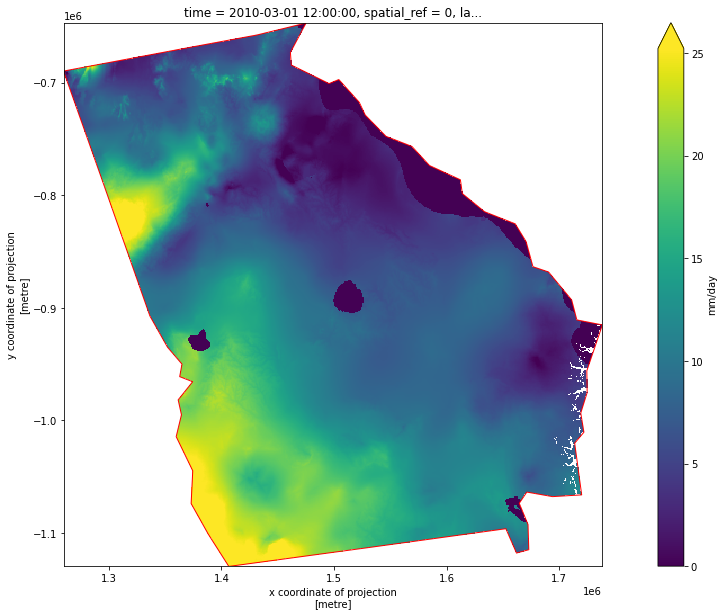

In [78]:
import rioxarray
from shapely.geometry import mapping

prcp_sub = rioxarray.open_rasterio(var + '_tdssubset.nc',  masked=True)
prcp_clip = prcp_sub.prcp.rio.clip(ga_shape_lcc.geometry.apply(mapping), ga_shape_lcc.crs, invert=False, from_disk=True)

import matplotlib.pyplot as plt
prcp_2 = prcp_clip.isel(time=59)#"2010-01-07")
fig, ax = plt.subplots(figsize = (20,10))
prcp_2.plot(ax=ax, robust=True, cbar_kwargs={'label': 'mm/day'})
ga_shape_lcc.plot(ax = ax, color = 'none', edgecolor = 'red')

# # saving one time step to geotiff
# prcp_clip_day60 = prcp_clip.isel(time=59)
# prcp_clip_day60.rio.to_raster("prcp_clip_day60.tif")
# fig.savefig("prcp_clip_day60.png")

In [33]:
# Define function that automates the subsetting of the data set over specified dates of time: 
# (June-August for all years 2000-2020)
def timeseries_subset():
        # all dates within the desired range of dates AND within the daymet data, rename.
        # name according to convention prcp_clip_day%time+1%
        # export clip as .tif
        
        #While loop
    for spec_year in range(2000, 2001):
        start_date = dt.datetime(spec_year, 6, 1) # specify your own start date
        end_date = dt.datetime(spec_year, 8, 31)  # specify your end start date
        beg_day = (start_date - dt.datetime(spec_year, 1, 1)).days
        end_day = beg_day + 92
        print(start_date)
        print(end_date)
        print(beg_day)
        print(end_day)
        
        for spec_day in range(beg_day, end_day):
            # rename and export
            print(str(spec_day))
#             prcp_clip_day60.rio.to_raster("prcp_clip_day60.tif")
#             fig.savefig("prcp_clip_day60.png")
timeseries_subset

            # prcp_2 = prcp_clip.isel(time=59)
            # Start from june first (indexed by day~) and then counted loop will automate through until end of august and no further
            
# Additionally, joining/merging the counties or census tracts boundaries and info with the DAYMET layer would be 
# facillitate identification of data

<function __main__.timeseries_subset()>

In [ ]:
for spec_year in range(2000, 2005):
        start_date = dt.datetime(spec_year, 5, 31) # specify your own start date
        end_date = dt.datetime(spec_year, 8, 31)  # specify your end start date
        beg_day = (start_date - dt.datetime(spec_year, 1, 1)).days
        end_day = beg_day + 92 
        print(start_date)
        print(end_date)
        print(beg_day)
        print(end_day)
        
        for spec_day in range(beg_day, end_day):
            # rename and export
            print(str(spec_day)) #spec_day will be the value to use to specify what time equals a particular day
            prcp_1day_export = prcp_clip.isel(time=spec_day)
            prcp_1day_export.rio.to_raster("prcp_1day_export" + "_" + str(spec_day) + "_" + str(spec_year) + ".tif")
            fig, ax = plt.subplots(figsize = (20,10))
            prcp_1day_export.plot(ax=ax, robust=True, cbar_kwargs={'label': 'mm/day'})
            ga_shape_lcc.plot(ax = ax, color = 'none', edgecolor = 'red')
            fig.savefig("prcp_1day_export" + "_" + str(spec_day) + "_" + str(spec_year) + ".png")
            

print("Finished")

2000-05-31 00:00:00
2000-08-31 00:00:00
151
243
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171


C:\Users\samsh\AppData\Local\Temp/ipykernel_6696/2004298317.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize = (20,10))


172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
2001-05-31 00:00:00
2001-08-31 00:00:00
150
242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
2002-05-31 00:00:00
2002-08-31 00:00:00
150
242
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212


In [70]:
fig.savefig("prcp_1day_export" + "_" + str(spec_day) + "_" + str(spec_year) + ".png")

In [ ]:
# pip install cftime

END